# 2D-CNN pipeline (images ready)

In [1]:
# =============================================
# ====== 1. Imports & Setup ======
# =============================================
import os, random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import iqr

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [28]:
# =============================================
# ====== 2. Google Drive Mount & Paths ======
# =============================================
from google.colab import drive
drive.mount('/content/drive/')

# # Unzip if needed
# !unzip /content/CR.zip -d /content/CR

IMG_DIR = "/content/drive/MyDrive/CR_16_auto_scale"
CSV_PATH = "/content/drive/MyDrive/target_train_488.csv"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [40]:
# =============================================
# ====== 3. Configurations ======
# =============================================
TARGETS = ['Moi', 'NDF', 'Starch']
IMG_SIZE = 16
batch_size = 50
epochs = 200
lr = 0.0001
n_splits = 5
seed = 42
plot_name = "RESAMP"

# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [41]:
# =============================================
# ====== 4. Data Loading & Scaling ======
# =============================================
df = pd.read_csv(CSV_PATH)
print("Data shape:", df.shape)

# Scale targets
y_scaler = StandardScaler()   # Auto-scale
targets_scaled = y_scaler.fit_transform(df[TARGETS].values.astype(np.float32))

Data shape: (488, 3)


In [44]:
# =============================================
# ====== 5. Dataset Class ======
# =============================================
class SoilImageDataset(Dataset):
    def __init__(self, df, img_dir, targets_scaled, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.targets = targets_scaled.astype(np.float32)
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{plot_name}_{idx}.png")
        img = Image.open(img_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
        img = self.transform(img)
        target = torch.from_numpy(self.targets[idx])
        return img, target

transform = transforms.Compose([transforms.ToTensor()])
dataset = SoilImageDataset(df, IMG_DIR, targets_scaled, transform)
print("Dataset length:", len(dataset))

Dataset length: 488


In [45]:
# # ====== CNN model (as in Table 2) ======
# class CNN2D(nn.Module):
#     def __init__(self, in_channels=1, num_outputs=3): # Changed num_outputs to 3
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
#         self.pool = nn.MaxPool2d(2,2)
#         self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
#         self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
#         self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
#         self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv5a = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv5b = nn.Conv2d(512, 512, 3, padding=1)

#         self.flattened = 512 * 2 * 2
#         self.fc1 = nn.Linear(self.flattened, 128)
#         self.fc2 = nn.Linear(128, num_outputs)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.conv1(x)); x = self.pool(x)
#         x = self.relu(self.conv2(x)); x = self.pool(x)
#         x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)
#         x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)
#         x = self.relu(self.conv5a(x)); x = self.relu(self.conv5b(x)); x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = self.relu(self.fc1(x))
#         return self.fc2(x)

**16*16 2D CNN**

In [49]:
# =============================================
# ====== 6. CNN Model (16x16 Input) ======
# =============================================
class CNN2D(nn.Module):
    def __init__(self, in_channels=1, num_outputs=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
        self.flattened = 512 * 1 * 1
        self.fc1 = nn.Linear(self.flattened, 128)
        self.fc2 = nn.Linear(128, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)); x = self.pool(x)  # 16→8
        x = self.relu(self.conv2(x)); x = self.pool(x)  # 8→4
        x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)  # 4→2
        x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)  # 2→1
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [50]:
# =============================================
# ====== 7. Metrics Function ======
# =============================================
def compute_metrics_orig(y_true, y_pred):
    results = []
    for i in range(y_true.shape[1]):
        yt, yp = y_true[:, i], y_pred[:, i]
        rmse = np.sqrt(mean_squared_error(yt, yp))
        r2 = r2_score(yt, yp)
        bias = np.mean(yp - yt)
        results.append({"RMSE": rmse, "R2": r2, "Bias": bias})
    return results

In [51]:
# =============================================
# ====== 8. Data Split ======
# =============================================
indices = np.arange(len(dataset))
trainval_idx, test_idx = train_test_split(indices, test_size=0.25, random_state=seed)


========== Fold 1/5 ==========
Epoch 10/200 | Avg Loss: 0.9772
Epoch 20/200 | Avg Loss: 0.8901
Epoch 30/200 | Avg Loss: 0.8943
Epoch 40/200 | Avg Loss: 0.8509
Epoch 50/200 | Avg Loss: 0.8482
Epoch 60/200 | Avg Loss: 0.7933
Epoch 70/200 | Avg Loss: 0.7369
Epoch 80/200 | Avg Loss: 0.7294
Epoch 90/200 | Avg Loss: 0.5931
Epoch 100/200 | Avg Loss: 0.5728
Epoch 110/200 | Avg Loss: 0.6215
Epoch 120/200 | Avg Loss: 0.5801
Epoch 130/200 | Avg Loss: 0.5912
Epoch 140/200 | Avg Loss: 0.5278
Epoch 150/200 | Avg Loss: 0.5333
Epoch 160/200 | Avg Loss: 0.5247
Epoch 170/200 | Avg Loss: 0.5523
Epoch 180/200 | Avg Loss: 0.5365
Epoch 190/200 | Avg Loss: 0.4997
Epoch 200/200 | Avg Loss: 0.4921

Fold Results:
Moi: RMSE=2.898, R2=0.789, Bias=-0.224


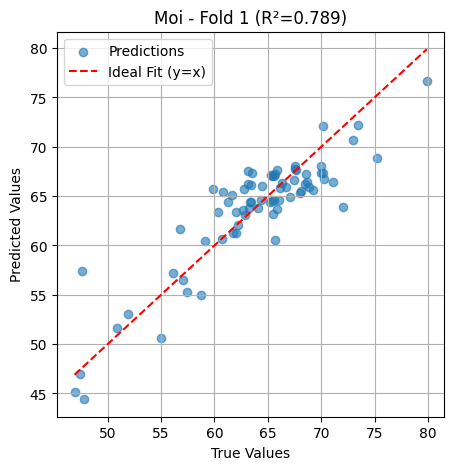

NDF: RMSE=4.546, R2=0.283, Bias=-0.166


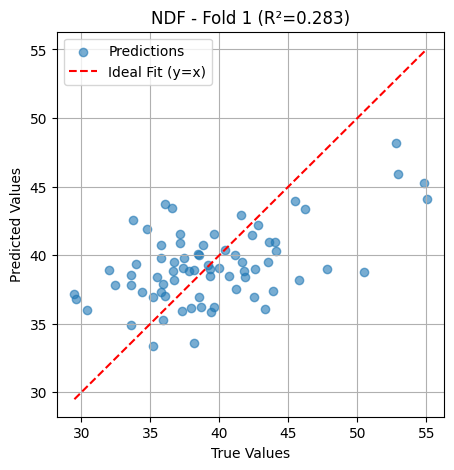

Starch: RMSE=7.121, R2=0.323, Bias=0.647


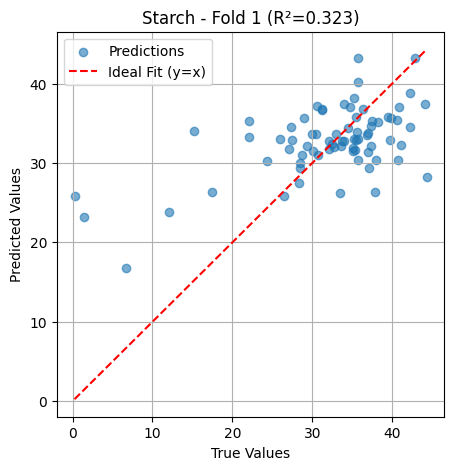


========== Fold 2/5 ==========
Epoch 10/200 | Avg Loss: 0.9829
Epoch 20/200 | Avg Loss: 0.8863
Epoch 30/200 | Avg Loss: 0.8788
Epoch 40/200 | Avg Loss: 0.8636
Epoch 50/200 | Avg Loss: 0.8319
Epoch 60/200 | Avg Loss: 0.7880
Epoch 70/200 | Avg Loss: 0.6844
Epoch 80/200 | Avg Loss: 0.6680
Epoch 90/200 | Avg Loss: 0.6511
Epoch 100/200 | Avg Loss: 0.5781
Epoch 110/200 | Avg Loss: 0.5402
Epoch 120/200 | Avg Loss: 0.5301
Epoch 130/200 | Avg Loss: 0.5430
Epoch 140/200 | Avg Loss: 0.5216
Epoch 150/200 | Avg Loss: 0.5084
Epoch 160/200 | Avg Loss: 0.4980
Epoch 170/200 | Avg Loss: 0.5368
Epoch 180/200 | Avg Loss: 0.4648
Epoch 190/200 | Avg Loss: 0.4740
Epoch 200/200 | Avg Loss: 0.4786

Fold Results:
Moi: RMSE=3.192, R2=0.755, Bias=1.115


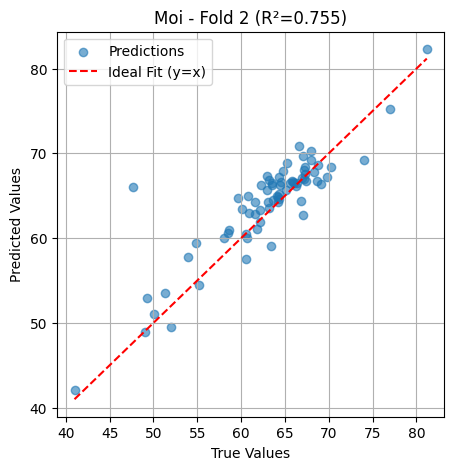

NDF: RMSE=4.539, R2=0.304, Bias=0.823


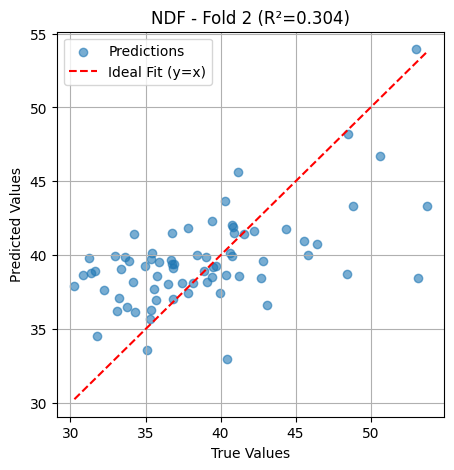

Starch: RMSE=6.690, R2=0.412, Bias=-0.260


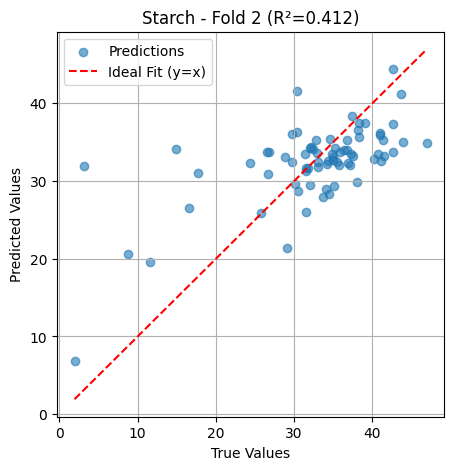


========== Fold 3/5 ==========
Epoch 10/200 | Avg Loss: 0.9269
Epoch 20/200 | Avg Loss: 0.8272
Epoch 30/200 | Avg Loss: 0.7889
Epoch 40/200 | Avg Loss: 0.7843
Epoch 50/200 | Avg Loss: 0.7779
Epoch 60/200 | Avg Loss: 0.7736
Epoch 70/200 | Avg Loss: 0.6692
Epoch 80/200 | Avg Loss: 0.5985
Epoch 90/200 | Avg Loss: 0.5768
Epoch 100/200 | Avg Loss: 0.5482
Epoch 110/200 | Avg Loss: 0.5508
Epoch 120/200 | Avg Loss: 0.4779
Epoch 130/200 | Avg Loss: 0.5032
Epoch 140/200 | Avg Loss: 0.4838
Epoch 150/200 | Avg Loss: 0.4885
Epoch 160/200 | Avg Loss: 0.4525
Epoch 170/200 | Avg Loss: 0.4643
Epoch 180/200 | Avg Loss: 0.4482
Epoch 190/200 | Avg Loss: 0.4341
Epoch 200/200 | Avg Loss: 0.4904

Fold Results:
Moi: RMSE=2.415, R2=0.811, Bias=-1.096


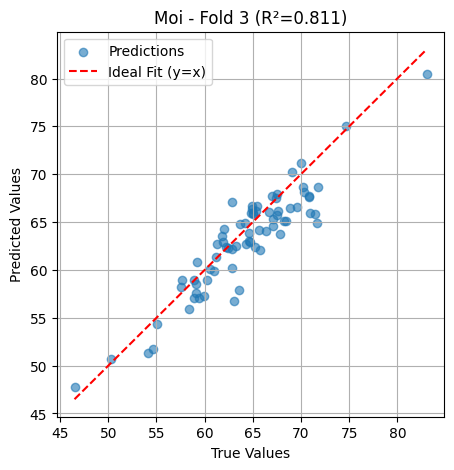

NDF: RMSE=7.243, R2=0.137, Bias=-1.748


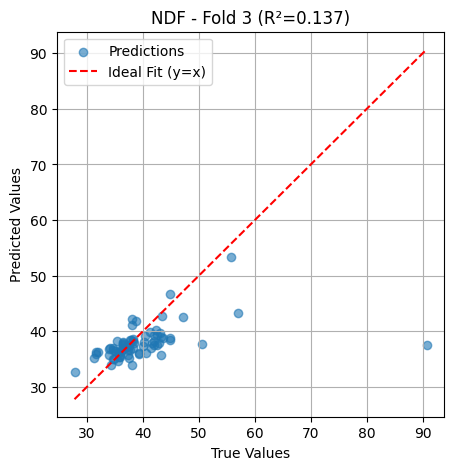

Starch: RMSE=6.895, R2=0.348, Bias=1.665


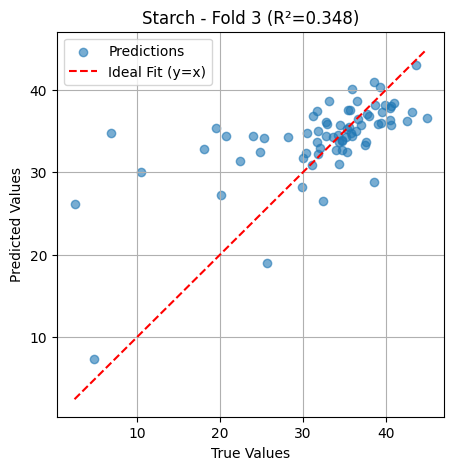


========== Fold 4/5 ==========
Epoch 10/200 | Avg Loss: 1.0027
Epoch 20/200 | Avg Loss: 0.9029
Epoch 30/200 | Avg Loss: 0.9149
Epoch 40/200 | Avg Loss: 0.8766
Epoch 50/200 | Avg Loss: 0.8541
Epoch 60/200 | Avg Loss: 0.8351
Epoch 70/200 | Avg Loss: 0.7915
Epoch 80/200 | Avg Loss: 0.6996
Epoch 90/200 | Avg Loss: 0.6212
Epoch 100/200 | Avg Loss: 0.6482
Epoch 110/200 | Avg Loss: 0.5927
Epoch 120/200 | Avg Loss: 0.5819
Epoch 130/200 | Avg Loss: 0.5737
Epoch 140/200 | Avg Loss: 0.5951
Epoch 150/200 | Avg Loss: 0.5646
Epoch 160/200 | Avg Loss: 0.5742
Epoch 170/200 | Avg Loss: 0.5374
Epoch 180/200 | Avg Loss: 0.5392
Epoch 190/200 | Avg Loss: 0.5330
Epoch 200/200 | Avg Loss: 0.5269

Fold Results:
Moi: RMSE=3.057, R2=0.736, Bias=-0.341


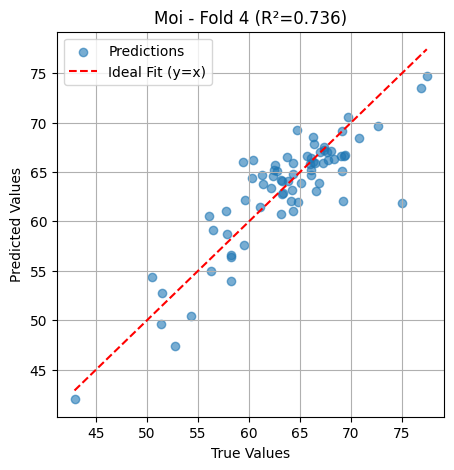

NDF: RMSE=4.577, R2=0.220, Bias=0.018


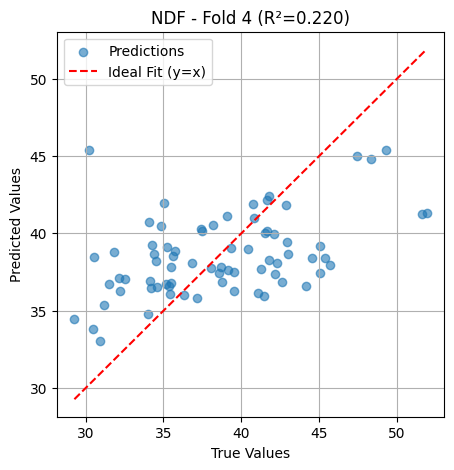

Starch: RMSE=7.571, R2=0.159, Bias=-0.165


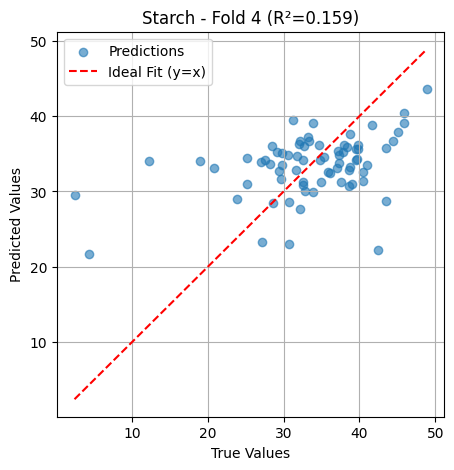


========== Fold 5/5 ==========
Epoch 10/200 | Avg Loss: 1.0319
Epoch 20/200 | Avg Loss: 0.9585
Epoch 30/200 | Avg Loss: 0.9220
Epoch 40/200 | Avg Loss: 0.9169
Epoch 50/200 | Avg Loss: 0.9027
Epoch 60/200 | Avg Loss: 0.8808
Epoch 70/200 | Avg Loss: 0.8921
Epoch 80/200 | Avg Loss: 0.8175
Epoch 90/200 | Avg Loss: 0.6782
Epoch 100/200 | Avg Loss: 0.7958
Epoch 110/200 | Avg Loss: 0.6511
Epoch 120/200 | Avg Loss: 0.6556
Epoch 130/200 | Avg Loss: 0.6015
Epoch 140/200 | Avg Loss: 0.6260
Epoch 150/200 | Avg Loss: 0.5924
Epoch 160/200 | Avg Loss: 0.5413
Epoch 170/200 | Avg Loss: 0.5315
Epoch 180/200 | Avg Loss: 0.5539
Epoch 190/200 | Avg Loss: 0.5370
Epoch 200/200 | Avg Loss: 0.5006

Fold Results:
Moi: RMSE=2.988, R2=0.780, Bias=-1.767


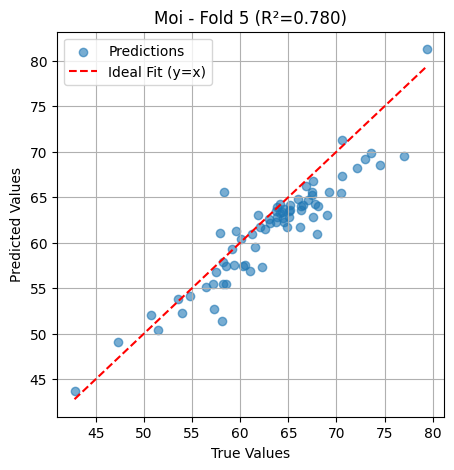

NDF: RMSE=4.059, R2=0.292, Bias=-0.403


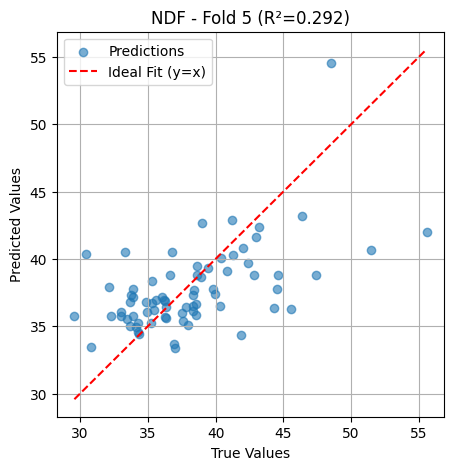

Starch: RMSE=5.860, R2=0.294, Bias=0.639


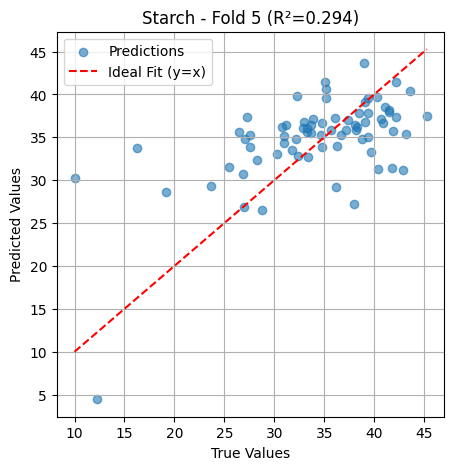

In [53]:
# =============================================
# ====== 9. 5-Fold Cross Validation ======
# =============================================
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

for fold, (t_idx, v_idx) in enumerate(kf.split(trainval_idx)):
    print(f"\n========== Fold {fold+1}/{n_splits} ==========")

    # Loaders
    train_loader = DataLoader(Subset(dataset, trainval_idx[t_idx]), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(Subset(dataset, trainval_idx[v_idx]), batch_size=batch_size, shuffle=False)

    model = CNN2D().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # ===== Training =====
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)

        # Print every 10 epochs
        if epoch % 10 == 0 or epoch == epochs:
            print(f"Epoch {epoch}/{epochs} | Avg Loss: {avg_loss:.4f}")

    # ===== Validation =====
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb.to(device)).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = y_scaler.inverse_transform(preds)
            yb_orig = y_scaler.inverse_transform(yb_np)
            y_true.append(yb_orig)
            y_pred.append(preds_orig)

    y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

    # ===== Metrics =====
    metrics = compute_metrics_orig(y_true, y_pred)
    print("\nFold Results:")
    for i, t in enumerate(TARGETS):
        print(f"{t}: RMSE={metrics[i]['RMSE']:.3f}, R2={metrics[i]['R2']:.3f}, Bias={metrics[i]['Bias']:.3f}")

        # ===== Plot Regression =====
        plt.figure(figsize=(5,5))
        plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
        min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title(f"{t} - Fold {fold+1} (R²={metrics[i]['R2']:.3f})")
        plt.legend()
        plt.grid(True)
        plt.show()


In [54]:
# =============================================
# ====== 10. Final Train on all trainval + test ======
# =============================================
final_loader = DataLoader(Subset(dataset, trainval_idx), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

final_model = CNN2D().to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
criterion = nn.MSELoss()

print("\n=== Final Training on Full Train+Val Set ===")
for epoch in range(1, epochs + 1):
    final_model.train()
    epoch_loss = 0.0
    for xb, yb in final_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(final_model(xb), yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch {epoch}/{epochs} | Train Loss: {epoch_loss / len(final_loader):.4f}")


=== Final Training on Full Train+Val Set ===
Epoch 10/200 | Train Loss: 0.9755
Epoch 20/200 | Train Loss: 0.8589
Epoch 30/200 | Train Loss: 0.8846
Epoch 40/200 | Train Loss: 0.8398
Epoch 50/200 | Train Loss: 0.6777
Epoch 60/200 | Train Loss: 0.6398
Epoch 70/200 | Train Loss: 0.7435
Epoch 80/200 | Train Loss: 0.5867
Epoch 90/200 | Train Loss: 0.5459
Epoch 100/200 | Train Loss: 0.5289
Epoch 110/200 | Train Loss: 0.5298
Epoch 120/200 | Train Loss: 0.5017
Epoch 130/200 | Train Loss: 0.4652
Epoch 140/200 | Train Loss: 0.4651
Epoch 150/200 | Train Loss: 0.4511
Epoch 160/200 | Train Loss: 0.4420
Epoch 170/200 | Train Loss: 0.4252
Epoch 180/200 | Train Loss: 0.4126
Epoch 190/200 | Train Loss: 0.4370
Epoch 200/200 | Train Loss: 0.5172



== Test metrics ==
Moi: RMSE=2.519, R2=0.838, Bias=-0.187


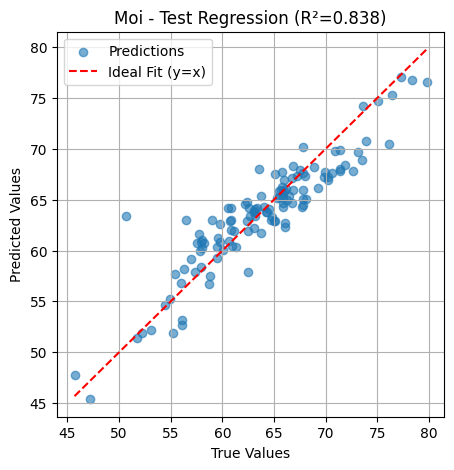

NDF: RMSE=4.212, R2=0.438, Bias=-0.391


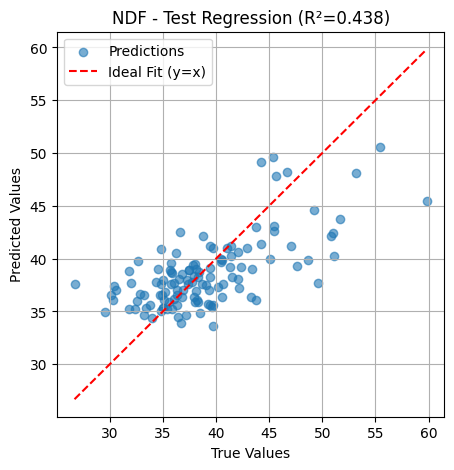

Starch: RMSE=5.648, R2=0.572, Bias=0.298


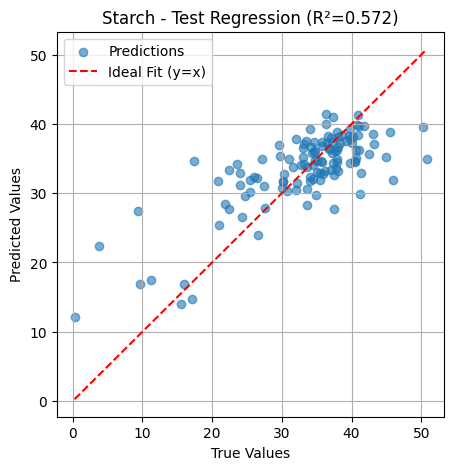

In [55]:
# =============================================
# ====== 11. Final Evaluation ======
# =============================================
final_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = final_model(xb.to(device)).cpu().numpy()
        yb_np = yb.cpu().numpy()
        preds_orig = y_scaler.inverse_transform(preds)
        yb_orig = y_scaler.inverse_transform(yb_np)
        y_true.append(yb_orig)
        y_pred.append(preds_orig)

y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

test_metrics = compute_metrics_orig(y_true, y_pred)
print("\n== Test metrics ==")
for i, t in enumerate(TARGETS):
    print(f"{t}: RMSE={test_metrics[i]['RMSE']:.3f}, R2={test_metrics[i]['R2']:.3f}, Bias={test_metrics[i]['Bias']:.3f}")
    plt.figure(figsize=(5,5))
    plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
    min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{t} - Test Regression (R²={test_metrics[i]['R2']:.3f})")
    plt.legend()
    plt.grid(True)
    plt.show()

In [57]:
# =============================================
# ====== 12. Save Model ======
# =============================================
file_path = f"/content/CR_16_auto.pth"
torch.save(final_model.state_dict(), file_path)
print(f"\n✅ Model saved to: {file_path}")


✅ Model saved to: /content/CR_16_auto.pth


In [58]:
# =============================================
# ====== 13. Targets Info ======
# =============================================
for target in TARGETS:
    print(f"{target}: Min={df[target].min():.3f}, Max={df[target].max():.3f}")

Moi: Min=41.001, Max=83.060
NDF: Min=26.690, Max=90.740
Starch: Min=0.250, Max=50.800
